# NBA EDA: Data Exploration & Feature Analysis

This notebook explores NBA data, computes features, and analyzes correlations with game outcomes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

from src.data import nba_fetcher
from src.features import rest_schedule, form_metrics, strength

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [ ]:
# Load Historical NBA Data (2020-2025)
seasons = [2020, 2021, 2022, 2023, 2024, 2025]
all_schedules = []

print("Loading NBA schedule data...")
for season in seasons:
    try:
        schedule = nba_fetcher.fetch_nba_schedule(season)
        if not schedule.empty:
            all_schedules.append(schedule)
            print(f"Loaded {season}: {len(schedule)} games")
        else:
            print(f"No data for {season}")
    except Exception as e:
        print(f"Error loading {season}: {e}")

if all_schedules:
    schedule_df = pd.concat(all_schedules, ignore_index=True)
    print(f"\nTotal games loaded: {len(schedule_df)}")
    
    # Ensure game_date is datetime
    schedule_df['game_date'] = pd.to_datetime(schedule_df['game_date'])
    
    # Compute margin and home win
    if 'home_score' in schedule_df.columns and 'away_score' in schedule_df.columns:
        schedule_df['margin'] = schedule_df['home_score'] - schedule_df['away_score']
        schedule_df['home_win'] = (schedule_df['margin'] > 0).astype(int)
        print(f"\nGames with scores: {schedule_df['home_win'].notna().sum()}")
        print(f"Home win rate: {schedule_df['home_win'].mean():.3f}")
    else:
        print("Warning: Score columns not found. Available columns:", schedule_df.columns.tolist())
    
    # Display summary
    print("\nSchedule DataFrame Info:")
    print(schedule_df.head())
    print(f"\nDate range: {schedule_df['game_date'].min()} to {schedule_df['game_date'].max()}")
else:
    print("No schedule data loaded!")


In [ ]:
# Load Game Logs for Form Metrics
# This is the NBA equivalent of PBP data - used for computing form statistics

print("Loading NBA game logs (this may take a few minutes)...")
print("Note: This loads game-by-game stats for all teams across all seasons")

try:
    from src.data.nba_game_logs_loader import load_nba_game_logs
    
    # Pass schedule_df to enable computing opponent points for defensive ratings
    game_logs_df = load_nba_game_logs(seasons, strict=False, schedule_df=schedule_df if 'schedule_df' in locals() else None)
    
    if game_logs_df is not None and len(game_logs_df) > 0:
        print(f"\nTotal game log entries loaded: {len(game_logs_df)}")
        print(f"Teams: {game_logs_df['team'].nunique()}")
        print(f"Date range: {game_logs_df['game_date'].min()} to {game_logs_df['game_date'].max()}")
        print("\nSample game logs:")
        print(game_logs_df.head())
        print("\nColumns:", game_logs_df.columns.tolist()[:15])
    else:
        print("Warning: Could not load game logs. Form features will be unavailable.")
        game_logs_df = None
except Exception as e:
    print(f"Error loading game logs: {e}")
    import traceback
    traceback.print_exc()
    game_logs_df = None


In [ ]:
# Apply Rest & Schedule Features
if 'schedule_df' in locals() and len(schedule_df) > 0:
    print("Computing rest and schedule features...")
    print("This includes back-to-back detection (critical for NBA)...")
    
    # Add rest features
    features_df = rest_schedule.add_rest_features(schedule_df, schedule_df)
    
    print("\nRest features added:")
    print(f"  - rest_home: {features_df['rest_home'].notna().sum()} values")
    print(f"  - rest_away: {features_df['rest_away'].notna().sum()} values")
    print(f"  - b2b_home: {features_df['b2b_home'].sum()} back-to-back games")
    print(f"  - b2b_away: {features_df['b2b_away'].sum()} back-to-back games")
    
    # Analyze rest day distributions
    if 'rest_home' in features_df.columns:
        print("\nRest Days Distribution (Home Teams):")
        rest_dist = features_df['rest_home'].value_counts().sort_index()
        print(rest_dist.head(10))
        
        # Visualize rest days impact
        if 'home_win' in features_df.columns:
            rest_analysis = features_df.groupby('rest_home')['home_win'].agg(['mean', 'count']).reset_index()
            rest_analysis.columns = ['rest_days', 'win_pct', 'games']
            rest_analysis = rest_analysis[rest_analysis['games'] >= 10]  # Filter to meaningful sample sizes
            
            plt.figure(figsize=(12, 6))
            plt.bar(rest_analysis['rest_days'], rest_analysis['win_pct'], alpha=0.7)
            plt.xlabel('Days of Rest (Home Team)', fontsize=12)
            plt.ylabel('Home Win Percentage', fontsize=12)
            plt.title('Home Win Rate by Days of Rest (NBA)', fontsize=14)
            plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='50% baseline')
            plt.grid(axis='y', alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            print("\nWin % by Rest Days (Home):")
            print(rest_analysis)
            
            # Back-to-back analysis (critical for NBA)
            if 'b2b_home' in features_df.columns:
                b2b_analysis = features_df.groupby('b2b_home')['home_win'].agg(['mean', 'count']).reset_index()
                b2b_analysis.columns = ['is_b2b', 'win_pct', 'games']
                print("\nBack-to-Back Impact (NBA - Very Important!):")
                print(b2b_analysis)
else:
    print("Schedule data not available. Run the previous cell first.")


In [ ]:
# Apply Form Features (Net Rating) - Using Cached Computation
# This uses game logs instead of PBP data

if 'features_df' in locals() and 'game_logs_df' in locals() and game_logs_df is not None:
    print("Computing form features (net rating, offensive/defensive ratings)...")
    print("Using cached computation for efficiency...")
    
    try:
        from src.utils.cache import cache_form_features
        
        # Use caching to avoid recomputing every time
        features_df = cache_form_features(
            features_df,
            game_logs_df,
            league='NBA',
            cache_name='nba_form_features'
        )
        
        print("\nForm features added:")
        form_cols = [col for col in features_df.columns if col.startswith('form_')]
        for col in sorted(form_cols):
            non_null = features_df[col].notna().sum()
            print(f"  - {col}: {non_null} values")
            
    except Exception as e:
        print(f"Error computing form features: {e}")
        import traceback
        traceback.print_exc()
        print("Falling back to direct computation...")
        
        # Fallback: compute directly without cache
        for window in [3, 5, 10]:
            print(f"  Computing {window}-game rolling form metrics...")
            features_df = form_metrics.add_form_features_nba(features_df, game_logs_df, window=window)
        
        print("\nForm features added (direct computation):")
        form_cols = [col for col in features_df.columns if col.startswith('form_')]
        for col in sorted(form_cols):
            non_null = features_df[col].notna().sum()
            print(f"  - {col}: {non_null} values")
else:
    print("Features DataFrame or game logs not available. Run previous cells first.")


In [ ]:
# Apply Opponent Strength Features
if 'features_df' in locals():
    print("Computing opponent strength features...")
    print("This may take a few minutes...")
    
    features_df = strength.add_opponent_strength_features(features_df, schedule_df, league='nba')
    
    print("\nOpponent strength features added:")
    print(f"  - opp_strength_home_season: {features_df['opp_strength_home_season'].notna().sum()} values")
    print(f"  - opp_strength_away_season: {features_df['opp_strength_away_season'].notna().sum()} values")
    
    if 'opp_strength_home_season' in features_df.columns:
        print(f"\nOpponent Strength Stats:")
        print(f"  Home team avg: {features_df['opp_strength_home_season'].mean():.2f}")
        print(f"  Away team avg: {features_df['opp_strength_away_season'].mean():.2f}")
else:
    print("Features DataFrame not available. Run previous cells first.")


In [ ]:
# Add Team Strength Features (Season-to-Date Performance)
if 'features_df' in locals() and 'schedule_df' in locals():
    print("Computing team strength features...")
    
    # Calculate season-to-date win percentage and point differential for each team
    def compute_team_strength_features(games_df, historical_games):
        df = games_df.copy()
        
        # Initialize columns
        df['home_team_win_pct'] = np.nan
        df['away_team_win_pct'] = np.nan
        df['home_team_point_diff'] = np.nan
        df['away_team_point_diff'] = np.nan
        
        for idx, row in df.iterrows():
            game_date = pd.to_datetime(row['game_date'])
            home_team = row['home_team']
            away_team = row['away_team']
            season = row.get('season', game_date.year)
            
            # Get all games before this date in the same season
            season_games = historical_games[
                (pd.to_datetime(historical_games['game_date']) < game_date) &
                (historical_games.get('season', pd.to_datetime(historical_games['game_date']).dt.year) == season)
            ]
            
            # Home team stats
            home_games = season_games[
                (season_games['home_team'] == home_team) | (season_games['away_team'] == home_team)
            ]
            if len(home_games) > 0:
                home_wins = 0
                home_point_diff = []
                for _, game in home_games.iterrows():
                    # Handle NaN values properly
                    home_score = pd.to_numeric(game.get('home_score'), errors='coerce')
                    away_score = pd.to_numeric(game.get('away_score'), errors='coerce')
                    
                    # Skip if scores are missing
                    if pd.isna(home_score) or pd.isna(away_score):
                        continue
                    
                    if game['home_team'] == home_team:
                        if home_score > away_score:
                            home_wins += 1
                        home_point_diff.append(home_score - away_score)
                    else:
                        if away_score > home_score:
                            home_wins += 1
                        home_point_diff.append(away_score - home_score)
                
                if len(home_point_diff) > 0:
                    df.loc[idx, 'home_team_win_pct'] = home_wins / len(home_games)
                    df.loc[idx, 'home_team_point_diff'] = np.mean(home_point_diff)
            
            # Away team stats
            away_games = season_games[
                (season_games['home_team'] == away_team) | (season_games['away_team'] == away_team)
            ]
            if len(away_games) > 0:
                away_wins = 0
                away_point_diff = []
                for _, game in away_games.iterrows():
                    # Handle NaN values properly
                    home_score = pd.to_numeric(game.get('home_score'), errors='coerce')
                    away_score = pd.to_numeric(game.get('away_score'), errors='coerce')
                    
                    # Skip if scores are missing
                    if pd.isna(home_score) or pd.isna(away_score):
                        continue
                    
                    if game['home_team'] == away_team:
                        if home_score > away_score:
                            away_wins += 1
                        away_point_diff.append(home_score - away_score)
                    else:
                        if away_score > home_score:
                            away_wins += 1
                        away_point_diff.append(away_score - home_score)
                
                if len(away_point_diff) > 0:
                    df.loc[idx, 'away_team_win_pct'] = away_wins / len(away_games)
                    df.loc[idx, 'away_team_point_diff'] = np.mean(away_point_diff)
        
        return df
    
    features_df = compute_team_strength_features(features_df, schedule_df)
    
    print("\nTeam strength features added:")
    print(f"  - home_team_win_pct: {features_df['home_team_win_pct'].notna().sum()} values")
    print(f"  - away_team_win_pct: {features_df['away_team_win_pct'].notna().sum()} values")
    print(f"  - home_team_point_diff: {features_df['home_team_point_diff'].notna().sum()} values")
    print(f"  - away_team_point_diff: {features_df['away_team_point_diff'].notna().sum()} values")
    
    if 'home_team_win_pct' in features_df.columns:
        print(f"\nTeam Strength Stats:")
        print(f"  Home team avg win %: {features_df['home_team_win_pct'].mean():.3f}")
        print(f"  Away team avg win %: {features_df['away_team_win_pct'].mean():.3f}")
else:
    print("Features DataFrame or schedule_df not available.")


In [ ]:
# Add Interaction and Derived Features
if 'features_df' in locals():
    print("Adding interaction and derived features...")
    
    # Rest differential
    if 'rest_home' in features_df.columns and 'rest_away' in features_df.columns:
        features_df['rest_differential'] = features_df['rest_home'] - features_df['rest_away']
        features_df['rest_advantage_home'] = (features_df['rest_home'] > features_df['rest_away']).astype(int)
        print("  - Added rest_differential and rest_advantage_home")
    
    # Team strength differentials
    if 'home_team_win_pct' in features_df.columns and 'away_team_win_pct' in features_df.columns:
        features_df['win_pct_differential'] = features_df['home_team_win_pct'] - features_df['away_team_win_pct']
        print("  - Added win_pct_differential")
    
    if 'home_team_point_diff' in features_df.columns and 'away_team_point_diff' in features_df.columns:
        features_df['point_diff_differential'] = features_df['home_team_point_diff'] - features_df['away_team_point_diff']
        print("  - Added point_diff_differential")
    
    # Opponent strength differential
    if 'opp_strength_home_season' in features_df.columns and 'opp_strength_away_season' in features_df.columns:
        features_df['opp_strength_differential'] = features_df['opp_strength_home_season'] - features_df['opp_strength_away_season']
        print("  - Added opp_strength_differential")
    
    # Week and time features
    if 'game_date' in features_df.columns:
        features_df['week_number'] = pd.to_datetime(features_df['game_date']).dt.isocalendar().week
        features_df['month'] = pd.to_datetime(features_df['game_date']).dt.month
        features_df['is_playoff'] = 0  # NBA doesn't have game_type column like NFL
        print("  - Added week_number, month, is_playoff")
    
    # Form differentials (if form features exist)
    form_cols = [col for col in features_df.columns if col.startswith('form_')]
    if form_cols:
        # Find matching home/away pairs for NBA
        for window in [3, 5, 10]:
            # Net rating differential
            home_net = f'form_home_net_rating_{window}'
            away_net = f'form_away_net_rating_{window}'
            if home_net in features_df.columns and away_net in features_df.columns:
                features_df[f'form_net_rating_diff_{window}'] = features_df[home_net] - features_df[away_net]
                print(f"  - Added form_net_rating_diff_{window}")
            
            # Offensive rating differential
            home_off = f'form_home_off_rating_{window}'
            away_off = f'form_away_off_rating_{window}'
            if home_off in features_df.columns and away_off in features_df.columns:
                features_df[f'form_off_rating_diff_{window}'] = features_df[home_off] - features_df[away_off]
                print(f"  - Added form_off_rating_diff_{window}")
            
            # Defensive rating differential
            home_def = f'form_home_def_rating_{window}'
            away_def = f'form_away_def_rating_{window}'
            if home_def in features_df.columns and away_def in features_df.columns:
                features_df[f'form_def_rating_diff_{window}'] = features_df[home_def] - features_df[away_def]
                print(f"  - Added form_def_rating_diff_{window}")
    
    print("\nInteraction features added successfully!")
else:
    print("Features DataFrame not available.")


In [ ]:
# Correlation Analysis with Home Win
if 'features_df' in locals() and 'home_win' in features_df.columns:
    # Collect all feature columns
    feature_cols = [
        'rest_home', 'rest_away', 'b2b_home', 'b2b_away',
        'opp_strength_home_season', 'opp_strength_away_season',
        'home_team_win_pct', 'away_team_win_pct',
        'home_team_point_diff', 'away_team_point_diff',
        'rest_differential', 'rest_advantage_home',
        'win_pct_differential', 'point_diff_differential',
        'opp_strength_differential', 'week_number', 'month', 'is_playoff'
    ]
    
    # Add form features if they exist
    form_cols = [col for col in features_df.columns if col.startswith('form_')]
    feature_cols.extend(form_cols)
    
    # Add interaction features
    interaction_cols = [col for col in features_df.columns if 'diff' in col.lower() or 'differential' in col.lower()]
    feature_cols.extend(interaction_cols)
    
    # Filter to columns that exist and have data
    available_cols = [col for col in feature_cols if col in features_df.columns]
    # Remove duplicates while preserving order
    seen = set()
    available_cols = [col for col in available_cols if not (col in seen or seen.add(col))]
    available_cols = [col for col in available_cols if features_df[col].notna().sum() > 100]
    
    if available_cols:
        print(f"Analyzing {len(available_cols)} features...")
        
        # Ensure DataFrame doesn't have duplicate columns (can cause correlation issues)
        corr_df = features_df[available_cols + ['home_win']].copy()
        
        # Compute correlations
        corr_data = corr_df.corr()['home_win'].drop('home_win')
        corr_data = corr_data.sort_values(ascending=False)
        
        # Remove any duplicate index entries (shouldn't happen, but safety check)
        corr_data = corr_data[~corr_data.index.duplicated(keep='first')]
        
        # Create visualization
        plt.figure(figsize=(10, max(8, len(available_cols) * 0.5)))
        corr_data.plot(kind='barh', color=['green' if x > 0 else 'red' for x in corr_data.values])
        plt.xlabel('Correlation with Home Win', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Feature Correlations with Home Win Probability (NBA)', fontsize=14)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nTop Features Affecting Home Win (by correlation):")
        print("=" * 60)
        for idx, (feature, corr) in enumerate(corr_data.head(10).items(), 1):
            print(f"{idx:2d}. {feature:35s} {corr:7.4f}")
        
        print("\nBottom Features (negative correlation):")
        print("=" * 60)
        for idx, (feature, corr) in enumerate(corr_data.tail(5).items(), 1):
            print(f"{idx:2d}. {feature:35s} {corr:7.4f}")
    else:
        print("No feature columns available for correlation analysis.")
else:
    print("Features DataFrame or home_win column not available.")


Data points available: 6877
Features: 45
Date range: 2021-01-10 to 2025-12-30

Time-series split:
Training set: 5501 samples (2021-01-10 to 2024-12-21)
Test set: 1376 samples (2024-12-21 to 2025-12-30)

Training Random Forest classifier...
Training LightGBM classifier...

Random Forest Performance:
  Accuracy: 0.6497

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.65      0.49      0.56       622
    Home Win       0.65      0.78      0.71       754

    accuracy                           0.65      1376
   macro avg       0.65      0.64      0.63      1376
weighted avg       0.65      0.65      0.64      1376


LightGBM Performance:
  Accuracy: 0.6432

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.63      0.53      0.57       622
    Home Win       0.65      0.74      0.69       754

    accuracy                           0.64      1376
   macro avg       0.64      0.63      0.63   

<Figure size 1000x2250 with 0 Axes>

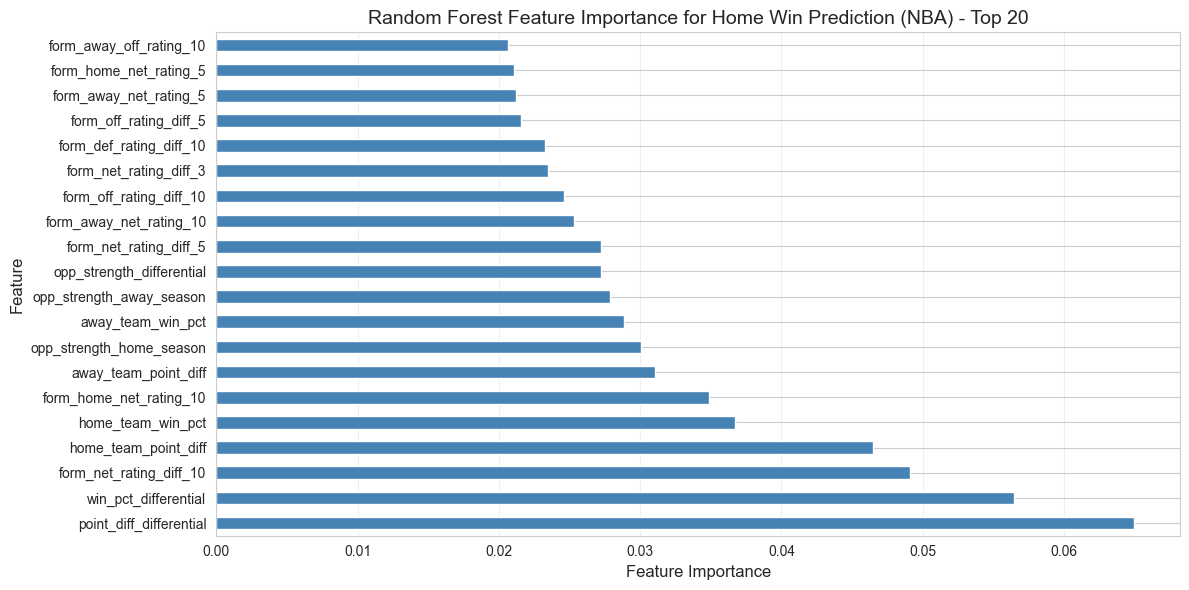


Feature Importance Rankings (Random Forest):
14. point_diff_differential                   0.0650
13. win_pct_differential                      0.0564
43. form_net_rating_diff_10                   0.0491
 9. home_team_point_diff                      0.0465
 7. home_team_win_pct                         0.0367
31. form_home_net_rating_10                   0.0349
10. away_team_point_diff                      0.0311
 5. opp_strength_home_season                  0.0301
 8. away_team_win_pct                         0.0288
 6. opp_strength_away_season                  0.0279
15. opp_strength_differential                 0.0272
40. form_net_rating_diff_5                    0.0272
32. form_away_net_rating_10                   0.0253
44. form_off_rating_diff_10                   0.0246
37. form_net_rating_diff_3                    0.0235
45. form_def_rating_diff_10                   0.0233
41. form_off_rating_diff_5                    0.0216
26. form_away_net_rating_5                    0.0212


In [23]:
# Feature Importance via Random Forest / LightGBM
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

if 'features_df' in locals() and 'home_win' in features_df.columns:
    # Collect feature columns
    feature_cols = [
        'rest_home', 'rest_away', 'b2b_home', 'b2b_away',
        'opp_strength_home_season', 'opp_strength_away_season',
        'home_team_win_pct', 'away_team_win_pct',
        'home_team_point_diff', 'away_team_point_diff',
        'rest_differential', 'rest_advantage_home',
        'win_pct_differential', 'point_diff_differential',
        'opp_strength_differential', 'week_number', 'month', 'is_playoff'
    ]
    
    # Add form features if they exist
    form_cols = [col for col in features_df.columns if col.startswith('form_')]
    feature_cols.extend(form_cols)
    
    # Add interaction features
    interaction_cols = [col for col in features_df.columns if 'diff' in col.lower() or 'differential' in col.lower()]
    feature_cols.extend(interaction_cols)
    
    # Filter to available columns AND remove duplicates
    available_cols = [col for col in feature_cols if col in features_df.columns]
    # Remove duplicates while preserving order
    seen = set()
    available_cols = [col for col in available_cols if not (col in seen or seen.add(col))]
    
    # Prepare data (drop NaN rows) - IMPORTANT: Sort by date for time-series split
    model_df = features_df[available_cols + ['home_win', 'game_date']].dropna()
    model_df = model_df.sort_values('game_date').reset_index(drop=True)
    
    print(f"Data points available: {len(model_df)}")
    print(f"Features: {len(available_cols)}")
    print(f"Date range: {model_df['game_date'].min().date()} to {model_df['game_date'].max().date()}")
    
    if len(model_df) > 100:
        X = model_df[available_cols]
        y = model_df['home_win']
        
        # TIME-SERIES SPLIT: Train on past, test on future
        split_idx = int(len(model_df) * 0.8)
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]
        
        print(f"\nTime-series split:")
        print(f"Training set: {len(X_train)} samples ({model_df['game_date'].iloc[0].date()} to {model_df['game_date'].iloc[split_idx-1].date()})")
        print(f"Test set: {len(X_test)} samples ({model_df['game_date'].iloc[split_idx].date()} to {model_df['game_date'].iloc[-1].date()})")
        
        # Train Random Forest
        print("\nTraining Random Forest classifier...")
        rf = RandomForestClassifier(
            n_estimators=200, 
            max_depth=12, 
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        # Also train LightGBM (often better for tabular data)
        print("Training LightGBM classifier...")
        try:
            lgbm = LGBMClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=7,
                num_leaves=31,
                random_state=42,
                verbose=-1
            )
            lgbm.fit(X_train, y_train)
            use_lgbm = True
        except Exception as e:
            print(f"LightGBM failed: {e}")
            print("Using Random Forest only")
            use_lgbm = False
        
        # Predictions
        y_pred_rf = rf.predict(X_test)
        y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
        
        if use_lgbm:
            y_pred_lgbm = lgbm.predict(X_test)
            y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
        
        # Metrics
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        print(f"\nRandom Forest Performance:")
        print(f"  Accuracy: {accuracy_rf:.4f}")
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred_rf, target_names=['Away Win', 'Home Win']))
        
        if use_lgbm:
            accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
            print(f"\nLightGBM Performance:")
            print(f"  Accuracy: {accuracy_lgbm:.4f}")
            print(f"\nClassification Report:")
            print(classification_report(y_test, y_pred_lgbm, target_names=['Away Win', 'Home Win']))
        
        # Feature importance (use best model)
        if use_lgbm and accuracy_lgbm > accuracy_rf:
            best_model = lgbm
            best_name = "LightGBM"
            importance_values = lgbm.feature_importances_
        else:
            best_model = rf
            best_name = "Random Forest"
            importance_values = rf.feature_importances_
        
        importance_df = pd.DataFrame({
            'feature': available_cols,
            'importance': importance_values
        }).sort_values('importance', ascending=False)
        
        # Visualize feature importance
        plt.figure(figsize=(10, max(8, len(available_cols) * 0.5)))
        importance_df.head(20).plot(x='feature', y='importance', kind='barh', legend=False, color='steelblue')
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'{best_name} Feature Importance for Home Win Prediction (NBA) - Top 20', fontsize=14)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\nFeature Importance Rankings ({best_name}):")
        print("=" * 60)
        for idx, row in importance_df.head(20).iterrows():
            print(f"{idx + 1:2d}. {row['feature']:40s} {row['importance']:7.4f}")
    else:
        print(f"Not enough data: {len(model_df)} rows (need >100)")
        print("Try loading more seasons or check data availability.")
else:
    print("Features DataFrame or home_win column not available.")


In [24]:
# Export Models for Production Use
# This cell trains and saves models in the format expected by the production pipeline

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

from src.pipeline.train_models import train_and_save_models

if 'features_df' in locals() and 'home_win' in features_df.columns and 'margin' in features_df.columns:
    print("=" * 70)
    print("TRAINING AND EXPORTING MODELS FOR PRODUCTION")
    print("=" * 70)
    
    # Use the feature columns from the trained model
    if 'available_cols' in locals():
        feature_cols_to_use = available_cols
    else:
        # Fallback: collect feature columns
        feature_cols_to_use = [
            'rest_home', 'rest_away', 'b2b_home', 'b2b_away',
            'opp_strength_home_season', 'opp_strength_away_season',
            'home_team_win_pct', 'away_team_win_pct',
            'home_team_point_diff', 'away_team_point_diff',
            'rest_differential', 'rest_advantage_home',
            'win_pct_differential', 'point_diff_differential',
            'opp_strength_differential', 'week_number', 'month', 'is_playoff'
        ]
        form_cols = [col for col in features_df.columns if col.startswith('form_')]
        feature_cols_to_use.extend(form_cols)
        interaction_cols = [col for col in features_df.columns if 'diff' in col.lower() or 'differential' in col.lower()]
        feature_cols_to_use.extend(interaction_cols)
        # Remove duplicates
        seen = set()
        feature_cols_to_use = [col for col in feature_cols_to_use if not (col in seen or seen.add(col))]
        # Filter to columns that exist
        feature_cols_to_use = [col for col in feature_cols_to_use if col in features_df.columns]
    
    print(f"\nUsing {len(feature_cols_to_use)} features for model training")
    
    # Ensure game_date is included for time-series split
    if 'game_date' not in features_df.columns:
        print("WARNING: game_date column missing - will use random split instead of time-series")
    
    # Train and save models
    try:
        results = train_and_save_models(
            features_df,
            target_col='home_win',
            margin_col='margin',
            feature_cols=feature_cols_to_use,
            league='NBA',
            model_version='v1',
            use_lgbm=True,
            test_size=0.2,
            random_state=42
        )
        
        print("\n" + "=" * 70)
        print("MODEL EXPORT COMPLETE")
        print("=" * 70)
        print(f"\nModels saved:")
        print(f"  - Win Probability: {results['win_prob_model_path']}")
        print(f"  - Spread: {results['spread_model_path']}")
        print(f"  - Link Function: {results['link_function_path']}")
        print(f"  - Feature Medians: {results['feature_medians_path']}")
        
        print(f"\nModel Performance:")
        print(f"  Win Probability Accuracy: {results['accuracy']:.4f}")
        print(f"  Spread MAE: {results['mae']:.2f} points")
        print(f"  Spread RMSE: {results['rmse']:.2f} points")
        print(f"  Link Function: a={results['link_params'][0]:.4f}, b={results['link_params'][1]:.4f}")
        
        print(f"\nYou can now use these models in production with:")
        print(f"  python scripts/predict_nba_date.py --date YYYY-MM-DD --season YYYY")
        
    except Exception as e:
        print(f"\nError training models: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Features DataFrame with home_win and margin columns not available.")
    print("Run previous cells to prepare data.")


TRAINING AND EXPORTING MODELS FOR PRODUCTION

Using 45 features for model training
Time-series split: Training on games from 2020-12-11 to 2024-12-21
Testing on games from 2024-12-21 to 2025-12-30
Training on 5890 samples, testing on 1473 samples
Features: 45

Training spread model...

Error training models: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: margin: object


Traceback (most recent call last):
  File "C:\Users\DMB\AppData\Local\Temp\ipykernel_2988\2649420705.py", line 47, in <module>
    results = train_and_save_models(
  File "c:\Users\DMB\OneDrive\Desktop\sports-edge\notebooks\..\src\pipeline\train_models.py", line 363, in train_and_save_models
    # --- END DTYPE CLEANUP ---
  File "c:\Users\DMB\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 1398, in fit
    super().fit(
  File "c:\Users\DMB\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    self._Booster = train(
  File "c:\Users\DMB\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py", line 297, in train
    booster = Booster(params=params, train_set=train_set)
  File "c:\Users\DMB\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py", line 3656, in __init__
    train_set.construct()
  File "c:\Users\DMB\AppData\Local\Programs\Python\Python310\lib\sit